Cryptocurrency trading bot.

Global variable definitions.

In [1]:
traded_asset_symbols = ['BTC', 'USDT']
intervals = ['1d']
all_pairs = False
raw_price = False
initial_plot = True

api_key = 'yoyoyo'
api_secret = 'yeyeye'

Installs.

In [2]:
!pip install plotly python-binance --upgrade --no-cache-dir

Requirement already up-to-date: plotly in ./anaconda3/lib/python3.7/site-packages (4.8.1)
Requirement already up-to-date: python-binance in ./anaconda3/lib/python3.7/site-packages (0.7.5)


Library imports.

In [3]:
%matplotlib inline

from binance.client import Client
from binance.enums import *
from binance.websockets import BinanceSocketManager
from binance.exceptions import BinanceAPIException
from twisted.internet import reactor
from IPython import display

import math
import random
import time
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go

Function definitions.

In [4]:
class Cryptocurrency_indicator:
    def __init__(self, name, calculate, OHLC=False):
        self.name = name
        self.calculate = calculate
        self.plot = self._plot_OHLC_ if OHLC else self._plot_default_
        self.value = None

    def update(self, dataset=None, plot=False):
        if dataset is not None:
            self.dataset = dataset

        self.value = self.calculate(self.dataset.astype(float))

        if plot:
            self.plot()

    def _plot_default_(self):
        value = self.value.astype(float)

        print(self.name)
        print(value)
        plt.plot(value)
        plt.show()
        print("\n")

    def _plot_OHLC_(self):
        value = self.value.astype(float)

        print(self.name)
        print(self.value)
        fig = go.Figure(data=[go.Candlestick(x=value.index.to_series(), 
                                             open=value['open'], 
                                             high=value['high'], 
                                             low=value['low'], 
                                             close=value['close'])])

        fig.show()
        print("\n")


class Cryptocurrency_indicators_base:
    def __init__(self):
        self.indicators = None

    def _calculate_moving_average_(self, dataset, window=2, method='simple'):
        if method == 'simple':
            dataset = dataset.rolling(window=window)
        elif method == 'exponential':
            dataset = dataset.ewm(span=window)

        dataset = dataset.mean()
        dataset = dataset.fillna(method='backfill', axis='index')
        return dataset

    def calculate_simple_moving_average(self, dataset, window=2):
        return self._calculate_moving_average_(dataset, window=window, method='simple')

    def calculate_exponential_moving_average(self, dataset, window=2):
        return self._calculate_moving_average_(dataset, window=window, method='exponential')

    def _calculate_heikin_ashi_(self, df):
        df = df.tz_localize(tz=None, ambiguous='infer')
        df = df[['open', 'high', 'low', 'close']].copy().astype('float')
        heikin_ashi_df = pd.DataFrame(index=df.index.values, columns=['open', 'high', 'low', 'close'])
        heikin_ashi_df['close'] = (df['open'] + df['high'] + df['low'] + df['close']) / 4

        for i in range(len(df)):
            if i == 0:
                heikin_ashi_df.iat[0, 0] = df['open'].iloc[0]
            else:
                heikin_ashi_df.iat[i, 0] = (heikin_ashi_df.iat[i - 1, 0] + heikin_ashi_df.iat[i - 1, 3]) / 2

        heikin_ashi_df['high'] = heikin_ashi_df.loc[:, ['open', 'close']].join(df['high']).max(axis=1)
        heikin_ashi_df['low'] = heikin_ashi_df.loc[:, ['open', 'close']].join(df['low']).min(axis=1)

        return heikin_ashi_df

    def calculate_heikin_ashi(self, df):
        heikin_ashi = self.calculate_simple_moving_average(df, window=1)
        heikin_ashi = self._calculate_heikin_ashi_(heikin_ashi)
        heikin_ashi = self.calculate_exponential_moving_average(heikin_ashi, window=1)

        return heikin_ashi

    def _calculate_RSI_(self, ticker, span=14):
        up = ticker['close'].astype(float).pct_change()
        down = up.copy()
        up[up < 0.0] = 0.0
        down[down > 0.0] = 0.0

        up = up.ewm(span=span).mean().fillna(method='pad')
        down = down.ewm(span=span).mean().abs().fillna(method='pad')

        ticker = up / down
        ticker = 100 - (100 / (1 + ticker))

        ticker = ticker.replace([-np.inf, np.inf], np.nan)
        ticker.iloc[0] = ticker.iloc[1]
        return ticker.fillna(method='pad')

    def calculate_RSI_6(self, ticker):
        return self._calculate_RSI_(ticker, span=6)

    def calculate_RSI_12(self, ticker):
        return self._calculate_RSI_(ticker, span=12)

    def calculate_MACD(self, ticker, span1=12, span2=26, average='exponential'):
        shorter = self._calculate_moving_average_(ticker, window=span1, method=average)['close']
        longer = self._calculate_moving_average_(ticker, window=span2, method=average)['close']

        ticker = (shorter - longer).replace([-np.inf, np.inf], np.nan)
        ticker.iloc[0] = ticker.iloc[1]
        ticker = ticker.fillna(method='pad').to_frame(name='MACD')
        ticker['signal_line'] = ticker.MACD.ewm(span=9).mean()
        ticker['histogram'] = ticker.MACD - ticker.signal_line
        return ticker

    def calculate_ATR(self, ticker, min_periods=14):
        ticker = ticker.astype(float)
        up = pd.DataFrame([ticker['high'].shift(), 
                           ticker['close']]).fillna(method='backfill', axis='columns').max(axis='index')

        down = pd.DataFrame([ticker['low'].shift(), 
                             ticker['close']]).fillna(method='backfill', axis='columns').min(axis='index')

        ticker = (up - down).ewm(alpha=1 / min_periods, 
                                 min_periods=min_periods, 
                                 adjust=False).mean()

        ticker = ticker.replace([-np.inf, np.inf], np.nan)
        return ticker.fillna(method='backfill')

    def calculate_bollinger_bands(self, dataframe, period=20):
        df = dataframe.copy()
        df['MA'] = self._calculate_moving_average_(df, window=period, method='simple')['close']
        df['BB_up'] = df['MA'] + df['MA'].rolling(period).std()
        df['BB_down'] = df['MA'] - df['MA'].rolling(period).std()
        df['BB_width'] = df['BB_up'] - df['BB_down']
        return df[['BB_up', 'BB_down', 'BB_width']].dropna()

    def calculate_average_directional_index(self, df, n=14, n_ADX=14):
        dataset_index = df.index.copy()
        df = df.reset_index().drop(columns=['time']).astype(float)
        i = 0
        UpI = []
        DoI = []

        while i + 1 <= df.index[-1]:
            UpMove = df.loc[i + 1, 'high'] - df.loc[i, 'high']
            DoMove = df.loc[i, 'low'] - df.loc[i + 1, 'low']

            if UpMove > DoMove and UpMove > 0:
                UpD = UpMove
            else:
                UpD = 0

            UpI.append(UpD)

            if DoMove > UpMove and DoMove > 0:
                DoD = DoMove
            else:
                DoD = 0

            DoI.append(DoD)
            i += 1

        ATR = self.calculate_ATR(df, min_periods=14)
        UpI = pd.Series(UpI)
        DoI = pd.Series(DoI)
        PosDI = pd.Series(UpI.ewm(span=n, min_periods=n).mean() / ATR, name='PosDI')
        NegDI = pd.Series(DoI.ewm(span=n, min_periods=n).mean() / ATR, name='NegDI')
        ADX = pd.Series((abs(PosDI - NegDI) / (PosDI + NegDI)).ewm(span=n_ADX, 
                                                                   min_periods=n_ADX).mean(), 
                        name='ADX')

        df = df.join(ADX).join(PosDI).join(NegDI)
        df.index = dataset_index
        return df[['ADX', 'PosDI', 'NegDI']].dropna()

    def calculate_commodity_channel_index(self, dataset, min_periods=20):
        PP = (dataset['high'] + dataset['low'] + dataset['close']) / 3
        CCI = pd.Series((PP - PP.rolling(min_periods, min_periods=min_periods).mean()) / \
                        PP.rolling(min_periods, min_periods=min_periods).std(),
                        name='CCI')
        return dataset.join(CCI)['CCI']

    def calculate_KDJ(self, dataset):
        def get_rsv(dataset):
            low_min = dataset['low'].rolling(min_periods=1, window=9, center=False).min()
            high_max = dataset['high'].rolling(min_periods=1, window=9, center=False).max()
            return ((dataset['close'] - low_min) / (high_max - low_min)).fillna(0).astype(float) * 100

        def calc_kd(column):
            k = 50.0
            for i in (1.0 / 3.0) * column:
                k = (2.0 / 3.0) * k + i
                yield k

        dataset['K'] = list(calc_kd(get_rsv(dataset)))
        dataset['D'] = list(calc_kd(dataset['K']))
        dataset['J'] = 3 * dataset['K'] - 2 * dataset['D']
        return dataset[['K', 'D', 'J']]

    def calculate_relative_volume_level(self, 
                                        dataset, 
                                        average_1=26, 
                                        average_2=14, 
                                        method='simple'):

        volume_average = self._calculate_moving_average_(dataset, 
                                                         window=average_1, 
                                                         method=method)

        relative_volume = dataset / average_1

        smoothed_relative_volume = self._calculate_moving_average_(relative_volume, 
                                                                   window=average_2, 
                                                                   method=method)

        return smoothed_relative_volume[['volume']].pct_change()


class Cryptocurrency_triggers:
    def __init__(self):
        self.indicators = Cryptocurrency_indicators_base()

    def calculate_trend_trigger(self, dataset):
        heikin_ashi = self.indicators.heikin_ashi.value
        return (heikin_ashi['close'] - heikin_ashi['open']) > 0

    def calculate_overtraded_trigger(self, dataset):
        RSI_6 = self.indicators.RSI_6.value
        RSI_12 = self.indicators.RSI_12.value
        return RSI_6 > RSI_12

    def calculate_trend_strength_trigger(self, dataset):
        ADX = self.indicators.average_directional_index.value
        return ADX['ADX'] > 0.25

    def calculate_trend_strength_positive_trigger(self, dataset):
        ADX = self.indicators.average_directional_index.value
        return ADX['PosDI'] > ADX['NegDI']

    def calculate_trend_strength_negative_trigger(self, dataset):
        ADX = self.indicators.average_directional_index.value
        return ADX['PosDI'] < ADX['NegDI']

    def calculate_momentum_trigger(self, dataset):
        KDJ = self.indicators.KDJ.value
        return KDJ['J'] > KDJ['D']

    def calculate_volatility_trigger(self, dataset):
        bollinger_bands = self.indicators.bollinger_bands.value
        return (bollinger_bands['BB_width'] / dataset['close']) > 0.0005

    def calculate_MACD_trigger(self, dataset):
        MACD = self.indicators.MACD.value
        return MACD['histogram'] > 0

    def calculate_real_trigger(self, dataset):
        return (dataset['close'] - dataset['open']) > 0

    def calculate_relative_volume_level_trigger(self, dataset, threshold=1.5):
        relative_volume_level = self.indicators.relative_volume_level.value
        return relative_volume_level['volume'] > threshold


class Cryptocurrency_indicators:
    def __init__(self):
        self.indicators = Cryptocurrency_triggers()
        self.setup()

    def setup(self):
        self._setup_(self.indicators)

    def update(self, dataset, plot=False):
        self._update_(self.indicators, dataset, plot=plot)

    def _setup_(self, cls):
        next_indicators = cls.indicators

        if next_indicators is not None:
            self._setup_(next_indicators)

        indicators = [indicator for indicator in dir(cls) if indicator.startswith('calculate_')]
        calculators = [getattr(cls, indicator) for indicator in indicators]

        for indicator, calculator in zip(indicators, calculators):
            setattr(cls, 
                    indicator[10:], 
                    Cryptocurrency_indicator(name=indicator[10:], 
                                             calculate=calculator, 
                                             OHLC=False))

    def _update_(self, cls, dataset, plot=False):
        next_indicators = cls.indicators

        if next_indicators is not None:
            self._update_(next_indicators, dataset, plot=plot)

        indicators = [indicator for indicator in dir(cls)]
        calculators = [getattr(cls, indicator) for indicator in indicators]

        for calculator in calculators:
            if isinstance(calculator, Cryptocurrency_indicator):
                calculator.update(dataset, plot=plot)


class Cryptocurrency_pair_info:
    def __init__(self, client, pair):
        self.client = client
        self.pair = pair

        pair_info = client.get_symbol_info(self.pair)
        self.base_asset = pair_info['baseAsset']
        self.quote_asset = pair_info['quoteAsset']
        self.precision = pair_info['quotePrecision']
        self.base_asset_precision = pair_info['baseAssetPrecision']

        filters = pair_info['filters']
        price_filter = [ticker for ticker in filters if ticker['filterType'] == 'PRICE_FILTER']
        lot_size = [ticker for ticker in filters if ticker['filterType'] == 'LOT_SIZE']
        self.tick_size = [ticker['tickSize'].find('1') - 2 for ticker in price_filter][0]
        self.step_size = [ticker['stepSize'].find('1') - 2 for ticker in lot_size][0]

        self.calculate_balance()

    def calculate_balance(self):
        self.base_asset_balance = float(self.client.get_asset_balance(asset=self.base_asset)['free'])        
        self.quote_asset_balance = float(self.client.get_asset_balance(asset=self.quote_asset)['free'])
        self.pair_last_price = float(self.client.get_ticker(symbol=self.pair)['lastPrice'])
        self.pair_buy_balance = float(self.quote_asset_balance) / float(self.pair_last_price)
        self.pair_sell_balance = float(self.base_asset_balance) * float(self.pair_last_price)
        self.pair_combined_base_balance = float(self.pair_buy_balance) + float(self.base_asset_balance)
        self.pair_combined_quote_balance = float(self.pair_sell_balance) + float(self.quote_asset_balance)

        self.base_asset_balance = "{:0.0{}f}".format(float(self.base_asset_balance), self.base_asset_precision).rstrip('0').rstrip('.')
        self.quote_asset_balance = "{:0.0{}f}".format(float(self.quote_asset_balance), self.precision).rstrip('0').rstrip('.')
        self.pair_last_price = "{:0.0{}f}".format(float(self.pair_last_price), self.precision).rstrip('0').rstrip('.')
        self.pair_buy_balance = "{:0.0{}f}".format(float(self.pair_buy_balance), self.base_asset_precision).rstrip('0').rstrip('.')
        self.pair_sell_balance = "{:0.0{}f}".format(float(self.pair_sell_balance), self.precision).rstrip('0').rstrip('.')
        self.pair_combined_base_balance = "{:0.0{}f}".format(float(self.pair_combined_base_balance), self.base_asset_precision).rstrip('0').rstrip('.')
        self.pair_combined_quote_balance = "{:0.0{}f}".format(float(self.pair_combined_quote_balance), self.precision).rstrip('0').rstrip('.')

    def print_balance(self):
        print("\n")
        print('pair: ', self.pair)
        print('base_asset_balance: ', self.base_asset_balance)
        print('quote_asset_balance: ', self.quote_asset_balance)
        print('pair_last_price: ', self.pair_last_price)
        print('pair_buy_balance: ', self.pair_buy_balance)
        print('pair_sell_balance: ', self.pair_sell_balance)
        print('pair_combined_base_balance: ', self.pair_combined_base_balance)
        print('pair_combined_quote_balance: ', self.pair_combined_quote_balance)
        print("\n")


class Cryptocurrency_pair_at_interval:
    def __init__(self, client, info, interval, download=True):
        self.dataset = pd.DataFrame(columns=['open', 'high', 'low', 'close', 'volume'])
        self.interval = interval
        self.period = self.get_n_periods_from_time(n=60)
        self.indicators = None

        if download:
            self.dataset = self.download_dataset(client=client, symbol=info.pair)

        if self.interval != 'price':
            self.indicators = Cryptocurrency_indicators()

    def get_n_periods_from_time(self, n=60):
        return str(int(self.interval[:-1]) * n) + self.interval[-1:]

    def download_dataset(self, client, symbol):
        if self.interval == 'price':
            return pd.DataFrame(client.get_recent_trades(symbol=symbol))
        else:
            dataset_downloaded = \
                client.get_historical_klines(symbol=symbol, 
                                             interval=self.interval, 
                                             start_str=self.period)

            dataset_downloaded = pd.DataFrame(dataset_downloaded, 
                                              columns=['time', 
                                                       'open', 
                                                       'high', 
                                                       'low', 
                                                       'close', 
                                                       'volume', 
                                                       'Close time', 
                                                       'Quote asset volume', 
                                                       'Number of trades', 
                                                       'Taker buy base asset volume', 
                                                       'Taker buy quote asset volume', 
                                                       'Ignore'])

            four_hours = 14400
            milliseconds = 1000

            dataset_downloaded['time'] = \
                dataset_downloaded['time'].apply(lambda timestamp: \
                                                 datetime.datetime.fromtimestamp((timestamp / \
                                                                                  milliseconds) - \
                                                                                 four_hours))

            dataset_downloaded = dataset_downloaded[['time', 
                                                     'open', 
                                                     'high', 
                                                     'low', 
                                                     'close', 
                                                     'volume']]

            dataset_downloaded.set_index('time', inplace=True)
            return dataset_downloaded.applymap(lambda entry: entry.rstrip('0').rstrip('.'))


class Cryptocurrency_trader:
    def __init__(self, pair):
        self.state = 'entry'
        self.is_tradable = True
        self.pair = pair
        self.info = self.pair.info

        self.calculate_position()

    def calculate_position(self):
        if float(self.info.pair_buy_balance) > float(self.info.base_asset_balance):
            self.position = 'sell'
        elif float(self.info.base_asset_balance) > float(self.info.pair_buy_balance):
            self.position = 'buy'

    def trade(self, percentage_to_trade=0.999999):
        if self.position == 'sell':
            coins_available = float(self.info.pair_buy_balance)
            side = Client.SIDE_BUY
            position = 'buy'
        elif self.position == 'buy':
            coins_available = float(self.info.base_asset_balance)
            side = Client.SIDE_SELL
            position = 'sell'

        coins_available *= percentage_to_trade
        quantity = math.floor(coins_available * 10**self.info.step_size) / \
                        float(10**self.info.step_size)

        if self.info.tick_size < 0:
            quantity = math.floor(coins_available * abs(self.info.tick_size)) / \
                            float(abs(self.info.tick_size))

        quantity = "{:0.0{}f}".format(float(quantity), self.info.precision).rstrip('0').rstrip('.')

        print('traded quantity:', quantity)
        self.pair.info.calculate_balance()
        client.create_order(symbol=self.info.pair, 
                            side=side, 
                            type=Client.ORDER_TYPE_MARKET, 
                            quantity=quantity, 
                            recvWindow=2000)

        self.pair.info.calculate_balance()
        self.pair.info.print_balance()

        if self.state == 'exit':
            self.state = 'entry'
        elif self.state == 'entry':
            self.state = 'exit'

        print("\nPosition for base asset " + self.info.base_asset + ' is ' + position + '.')
        print('Position for quote asset ' + self.info.quote_asset + ' is ' + self.position + '.')
        print('State is ' + self.state + ".\n")
        self.position = position


class Cryptocurrency_pair(Cryptocurrency_trader):
    def __init__(self, 
                 client, 
                 pair, 
                 intervals=intervals, 
                 raw_price=True, 
                 download=True):

        self.raw_price = raw_price
        self.download = download

        if self.raw_price:
            intervals = intervals + ['price']

        self.info = self.get_pair_info(client, pair)

        super().__init__(self)

        self.interval = self.get_datasets(client, intervals)

    def get_pair_info(self, client, pair):
        return Cryptocurrency_pair_info(client=client, pair=pair)

    def get_datasets(self, client, intervals):
        dataset = dict()

        for interval in intervals:
            dataset[interval] = Cryptocurrency_pair_at_interval(client=client, 
                                                                info=self.info, 
                                                                interval=interval, 
                                                                download=self.download)

        return dataset

    def make_OHLC_dataset(self, dataset, interval=intervals[0]):
        dataset = dataset.resample(interval)
        volume = dataset.agg({'quantity': ['sum']})['quantity']
        dataset = dataset.agg({'price': ['first', 'max', 'min', 'last']})['price']
        dataset['volume'] = volume
        dataset = dataset.dropna(axis='index')
        dataset = dataset.rename(columns={'first': 'open', 
                                          'max': 'high', 
                                          'min': 'low', 
                                          'last': 'close', 
                                          'sum': 'volume'})

        return dataset


class Cryptocurrency_bot:
    def __init__(self, 
                 client, 
                 traded_asset_symbols=traded_asset_symbols, 
                 intervals=intervals, 
                 raw_price=False, 
                 initial_plot=False, 
                 all_pairs=False):

        self.all_symbols = self.get_all_symbols(client)

        self.traded_pair_symbols = self.get_traded_pairs_from_assets(traded_asset_symbols)

        if all_pairs:
            self.traded_pair_symbols = self.all_symbols

        self.pairs = self.get_pairs(client, 
                                    intervals, 
                                    raw_price, 
                                    self.traded_pair_symbols)

        if all_pairs:
            self.traded_asset_symbols = [
                list(set([self.pairs[pair].info.base_asset]) | \
                     set([self.pairs[pair].info.quote_asset])) \
                for pair in self.pairs.keys()
            ]
        else:
            self.traded_asset_symbols = traded_asset_symbols

        self.assets = dict.fromkeys(self.traded_asset_symbols, 0)

        self.traded_asset_symbol = self.get_richest_asset(self.traded_asset_symbols, 
                                                          self.traded_pair_symbols)

        self.traded_pair_symbol = self.get_most_promising_pair()

        for pair in list(self.pairs.keys()):
            for interval in intervals:
                if initial_plot:
                    print("\n")
                    print('pair: ', pair)
                    print('interval: ', interval)

                self.pairs[pair].interval[interval].indicators.update(
                    self.pairs[pair].interval[interval].dataset, 
                    plot=initial_plot
                )

    def get_most_promising_pair(self):
        tradable_pair_symbols = []

        for symbol in self.pairs.keys():
            if self.pairs[symbol].is_tradable is True and \
                    (self.pairs[symbol].info.base_asset == self.traded_asset_symbol or \
                     self.pairs[symbol].info.quote_asset == self.traded_asset_symbol):
                tradable_pair_symbols.append(symbol)

        return random.choice(tradable_pair_symbols)

    def get_all_symbols(self, client):
        return [symbol['symbol'] for symbol in client.get_all_tickers()]

    def get_traded_pairs_from_assets(self, traded_asset_symbols):
        traded_pair_symbols = []
        for base_asset in traded_asset_symbols:
            for quote_asset in traded_asset_symbols:
                if base_asset != quote_asset:
                    for pair in [base_asset + quote_asset, quote_asset + base_asset]:
                        if pair in self.all_symbols:
                            traded_pair_symbols.append(pair)

        return traded_pair_symbols

    def get_pairs(self, 
                  client, 
                  intervals, 
                  raw_price, 
                  traded_pair_symbols):

        pairs = dict()
        for pair in traded_pair_symbols:
            try:
                pairs[pair] = Cryptocurrency_pair(client=client, 
                                                  pair=pair, 
                                                  intervals=intervals, 
                                                  raw_price=raw_price, 
                                                  download=True)

            except ZeroDivisionError:
                pass

        return pairs

    def get_richest_asset(self, traded_asset_symbols, traded_pair_symbols):
        richest_count = dict()
        for traded_asset_symbol in traded_asset_symbols:
            richest_count.update({traded_asset_symbol: 0})

        for traded_pair_symbol in traded_pair_symbols:
            base_asset = self.pairs[traded_pair_symbol].info.base_asset
            quote_asset = self.pairs[traded_pair_symbol].info.quote_asset
            if self.pairs[traded_pair_symbol].info.base_asset_balance >= \
                    self.pairs[traded_pair_symbol].info.quote_asset_balance:
                richest_count.update({base_asset: richest_count[base_asset] + 1})
            elif self.pairs[traded_pair_symbol].info.base_asset_balance < \
                    self.pairs[traded_pair_symbol].info.quote_asset_balance:
                richest_count.update({quote_asset: richest_count[quote_asset] + 1})

        return max(richest_count, key=richest_count.get)



pair:  BTCUSDT
interval:  1d
ATR
time
2020-04-22 16:00:00    615.383807
2020-04-23 16:00:00    615.383807
2020-04-24 16:00:00    615.383807
2020-04-25 16:00:00    615.383807
2020-04-26 16:00:00    615.383807
2020-04-27 16:00:00    615.383807
2020-04-28 16:00:00    615.383807
2020-04-29 16:00:00    615.383807
2020-04-30 16:00:00    615.383807
2020-05-01 16:00:00    615.383807
2020-05-02 16:00:00    615.383807
2020-05-03 16:00:00    615.383807
2020-05-04 16:00:00    615.383807
2020-05-05 16:00:00    615.383807
2020-05-06 16:00:00    648.584249
2020-05-07 16:00:00    676.971089
2020-05-08 16:00:00    664.084582
2020-05-09 16:00:00    701.755684
2020-05-10 16:00:00    755.760992
2020-05-11 16:00:00    770.920921
2020-05-12 16:00:00    771.611570
2020-05-13 16:00:00    787.852886
2020-05-14 16:00:00    780.309108
2020-05-15 16:00:00    774.259886
2020-05-16 16:00:00    751.815609
2020-05-17 16:00:00    738.535922
2020-05-18 16:00:00    720.481214
2020-05-19 16:00:00    699.247556
2020-05-

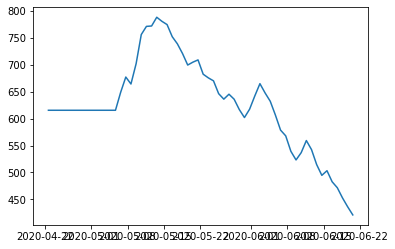



KDJ
                             K          D           J
time                                                 
2020-04-22 16:00:00  54.799907  51.599969   61.199783
2020-04-23 16:00:00  59.049520  54.083153   68.982255
2020-04-24 16:00:00  63.445734  57.204013   75.929176
2020-04-25 16:00:00  73.545995  62.651341   95.335305
2020-04-26 16:00:00  81.612721  68.971801  106.894562
2020-04-27 16:00:00  85.451718  74.465106  107.424941
2020-04-28 16:00:00  87.294939  78.741717  104.401382
2020-04-29 16:00:00  80.054549  79.179328   81.804992
2020-04-30 16:00:00  78.054945  78.804534   76.555769
2020-05-01 16:00:00  77.520060  78.376376   75.807429
2020-05-02 16:00:00  75.717176  77.489976   72.171577
2020-05-03 16:00:00  73.911788  76.297247   69.140870
2020-05-04 16:00:00  74.729937  75.774810   72.640190
2020-05-05 16:00:00  77.284309  76.277976   79.296973
2020-05-06 16:00:00  83.716314  78.757422   93.634099
2020-05-07 16:00:00  83.802273  80.439039   90.528740
2020-05-08 16:00:00  7

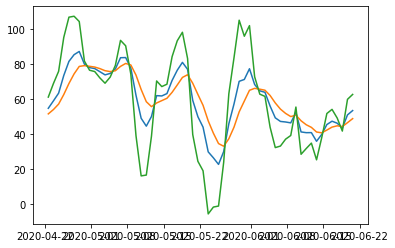



MACD
                           MACD  signal_line  histogram
time                                                   
2020-04-22 16:00:00    0.507276     0.507276   0.000000
2020-04-23 16:00:00    0.507276     0.507276   0.000000
2020-04-24 16:00:00    1.690475     0.992193   0.698281
2020-04-25 16:00:00    7.762824     3.285767   4.477056
2020-04-26 16:00:00   14.142889     6.515515   7.627373
2020-04-27 16:00:00   16.188347     9.137390   7.050956
2020-04-28 16:00:00   64.316459    23.101741  41.214718
2020-04-29 16:00:00   88.012154    38.700934  49.311220
2020-04-30 16:00:00  113.349873    55.945209  57.404664
2020-05-01 16:00:00  137.148150    74.139382  63.008769
2020-05-02 16:00:00  148.272139    90.359205  57.912933
2020-05-03 16:00:00  153.191009   103.852842  49.338167
2020-05-04 16:00:00  163.272717   116.428152  46.844565
2020-05-05 16:00:00  175.716350   128.831287  46.885063
2020-05-06 16:00:00  232.912211   150.406585  82.505625
2020-05-07 16:00:00  262.080131   173.388

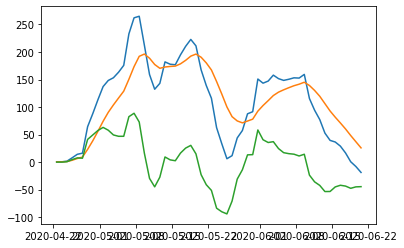



RSI_12
time
2020-04-22 16:00:00    100.000000
2020-04-23 16:00:00    100.000000
2020-04-24 16:00:00    100.000000
2020-04-25 16:00:00    100.000000
2020-04-26 16:00:00    100.000000
2020-04-27 16:00:00     85.888071
2020-04-28 16:00:00     97.602932
2020-04-29 16:00:00     86.227542
2020-04-30 16:00:00     88.358790
2020-05-01 16:00:00     89.654140
2020-05-02 16:00:00     83.831617
2020-05-03 16:00:00     82.021620
2020-05-04 16:00:00     84.669115
2020-05-05 16:00:00     86.531513
2020-05-06 16:00:00     93.221038
2020-05-07 16:00:00     83.325715
2020-05-08 16:00:00     70.690597
2020-05-09 16:00:00     44.829214
2020-05-10 16:00:00     41.001161
2020-05-11 16:00:00     49.092544
2020-05-12 16:00:00     61.287538
2020-05-13 16:00:00     69.260266
2020-05-14 16:00:00     56.400126
2020-05-15 16:00:00     57.729585
2020-05-16 16:00:00     63.712487
2020-05-17 16:00:00     64.743400
2020-05-18 16:00:00     65.629287
2020-05-19 16:00:00     55.256513
2020-05-20 16:00:00     41.802208


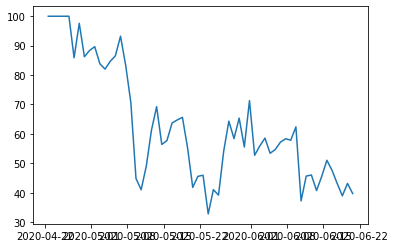



RSI_6
time
2020-04-22 16:00:00    100.000000
2020-04-23 16:00:00    100.000000
2020-04-24 16:00:00    100.000000
2020-04-25 16:00:00    100.000000
2020-04-26 16:00:00    100.000000
2020-04-27 16:00:00     81.682601
2020-04-28 16:00:00     97.848732
2020-04-29 16:00:00     83.907808
2020-04-30 16:00:00     87.280129
2020-05-01 16:00:00     89.407681
2020-05-02 16:00:00     79.567062
2020-05-03 16:00:00     76.191544
2020-05-04 16:00:00     83.017728
2020-05-05 16:00:00     87.124191
2020-05-06 16:00:00     96.129779
2020-05-07 16:00:00     80.235039
2020-05-08 16:00:00     60.335350
2020-05-09 16:00:00     28.490125
2020-05-10 16:00:00     24.569636
2020-05-11 16:00:00     42.129000
2020-05-12 16:00:00     64.570646
2020-05-13 16:00:00     76.338912
2020-05-14 16:00:00     53.173824
2020-05-15 16:00:00     55.861400
2020-05-16 16:00:00     67.726283
2020-05-17 16:00:00     69.718368
2020-05-18 16:00:00     71.602214
2020-05-19 16:00:00     46.177818
2020-05-20 16:00:00     24.872560
2

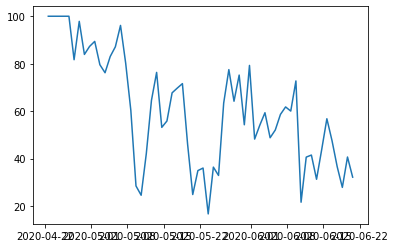



average_directional_index
                          ADX     PosDI     NegDI
time                                             
2020-05-18 16:00:00  0.285163  0.169464  0.112130
2020-05-19 16:00:00  0.262898  0.150898  0.199089
2020-05-20 16:00:00  0.244322  0.129476  0.170825
2020-05-21 16:00:00  0.224329  0.118336  0.146856
2020-05-22 16:00:00  0.237732  0.106348  0.205157
2020-05-23 16:00:00  0.253000  0.092943  0.190721
2020-05-24 16:00:00  0.260279  0.088737  0.166427
2020-05-25 16:00:00  0.237485  0.122756  0.149367
2020-05-26 16:00:00  0.230688  0.192495  0.131381
2020-05-27 16:00:00  0.224873  0.164315  0.112147
2020-05-28 16:00:00  0.231587  0.172763  0.098534
2020-05-29 16:00:00  0.237351  0.154275  0.087989
2020-05-30 16:00:00  0.283287  0.288134  0.078094
2020-05-31 16:00:00  0.301741  0.243310  0.099673
2020-06-01 16:00:00  0.317637  0.202779  0.083069
2020-06-02 16:00:00  0.342268  0.208145  0.069482
2020-06-03 16:00:00  0.363517  0.185125  0.061797
2020-06-04 16:00:00  0

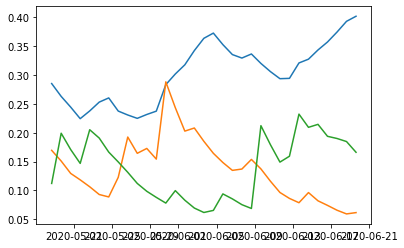



bollinger_bands
                           BB_up      BB_down    BB_width
time                                                     
2020-05-11 16:00:00  8614.105000  8614.105000    0.000000
2020-05-12 16:00:00  8725.880257  8685.027743   40.852515
2020-05-13 16:00:00  8869.137765  8770.468235   98.669529
2020-05-14 16:00:00  8988.141072  8829.239928  158.901143
2020-05-15 16:00:00  9104.067840  8882.130160  221.937680
2020-05-16 16:00:00  9233.757883  8942.982117  290.775766
2020-05-17 16:00:00  9370.455005  9005.779995  364.675010
2020-05-18 16:00:00  9452.623457  9023.307543  429.315914
2020-05-19 16:00:00  9525.684472  9039.389528  486.294943
2020-05-20 16:00:00  9559.982064  9029.260936  530.721128
2020-05-21 16:00:00  9586.910368  9022.127632  564.782737
2020-05-22 16:00:00  9614.077752  9023.459248  590.618504
2020-05-23 16:00:00  9614.074278  9008.300722  605.773555
2020-05-24 16:00:00  9610.872686  8999.354314  611.518372
2020-05-25 16:00:00  9593.721507  8986.331493  607.390

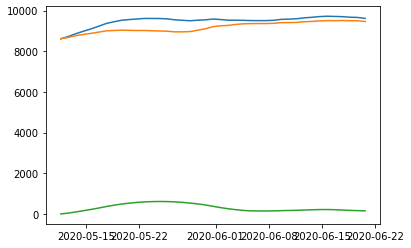



commodity_channel_index
time
2020-04-22 16:00:00         NaN
2020-04-23 16:00:00         NaN
2020-04-24 16:00:00         NaN
2020-04-25 16:00:00         NaN
2020-04-26 16:00:00         NaN
2020-04-27 16:00:00         NaN
2020-04-28 16:00:00         NaN
2020-04-29 16:00:00         NaN
2020-04-30 16:00:00         NaN
2020-05-01 16:00:00         NaN
2020-05-02 16:00:00         NaN
2020-05-03 16:00:00         NaN
2020-05-04 16:00:00         NaN
2020-05-05 16:00:00         NaN
2020-05-06 16:00:00         NaN
2020-05-07 16:00:00         NaN
2020-05-08 16:00:00         NaN
2020-05-09 16:00:00         NaN
2020-05-10 16:00:00         NaN
2020-05-11 16:00:00    0.237615
2020-05-12 16:00:00    0.681011
2020-05-13 16:00:00    1.267212
2020-05-14 16:00:00    0.867739
2020-05-15 16:00:00    0.739023
2020-05-16 16:00:00    1.099080
2020-05-17 16:00:00    1.295195
2020-05-18 16:00:00    1.191740
2020-05-19 16:00:00    0.730976
2020-05-20 16:00:00   -0.320343
2020-05-21 16:00:00   -0.430179
2020-05-2

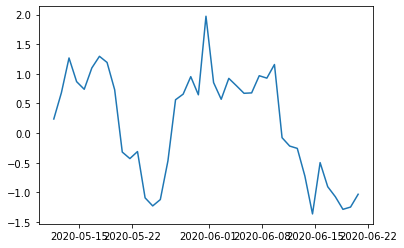



exponential_moving_average
                            open          high          low        close  \
time                                                                       
2020-04-22 16:00:00  7125.120000   7738.000000  7020.000000  7482.390000   
2020-04-23 16:00:00  7394.250000   7646.470000  7296.000000  7499.347500   
2020-04-24 16:00:00  7470.923077   7686.990769  7389.510000  7526.570769   
2020-04-25 16:00:00  7516.895250   7695.772000  7450.590750  7638.978000   
2020-04-26 16:00:00  7634.850496   7760.202479  7554.625041  7729.779669   
2020-04-27 16:00:00  7727.417143   7773.418956  7624.384038  7735.921648   
2020-04-28 16:00:00  7734.862452   8560.092690  7681.520805  8431.338527   
2020-04-29 16:00:00  8430.780220   9160.122351  8161.246720  8557.132015   
2020-04-30 16:00:00  8556.933149   9092.824031  8462.804227  8737.026478   
2020-05-01 16:00:00  8736.094084   9037.607075  8656.271352  8893.711479   
2020-05-02 16:00:00  8893.752251   9145.869636  8693.423994

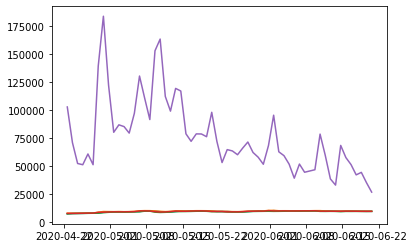



heikin_ashi
                            open          high          low      close
2020-04-22 16:00:00  7125.120000   7738.000000  7020.000000  7341.3775
2020-04-23 16:00:00  7233.248750   7615.960000  7233.248750  7498.2300
2020-04-24 16:00:00  7365.739375   7705.000000  7365.739375  7544.9350
2020-04-25 16:00:00  7455.337187   7700.000000  7455.337187  7603.0325
2020-04-26 16:00:00  7529.184844   7792.020000  7529.184844  7716.4350
2020-04-27 16:00:00  7622.809922   7780.000000  7622.809922  7737.9025
2020-04-28 16:00:00  7680.356211   8952.890000  7680.356211  8295.0225
2020-04-29 16:00:00  7987.689355   9460.000000  7987.689355  8814.8950
2020-04-30 16:00:00  8401.292178   9059.180000  8401.292178  8779.9250
2020-05-01 16:00:00  8590.608589   9010.000000  8590.608589  8890.1800
2020-05-02 16:00:00  8740.394294   9200.000000  8712.000000  8944.6850
2020-05-03 16:00:00  8842.539647   8950.000000  8522.000000  8809.5275
2020-05-04 16:00:00  8826.033574   9118.580000  8760.000000  89

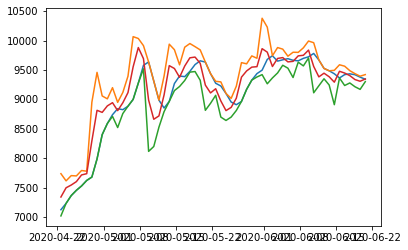



relative_volume_level
                       volume
time                         
2020-04-22 16:00:00       NaN
2020-04-23 16:00:00  0.000000
2020-04-24 16:00:00  0.000000
2020-04-25 16:00:00  0.000000
2020-04-26 16:00:00  0.000000
2020-04-27 16:00:00  0.000000
2020-04-28 16:00:00  0.000000
2020-04-29 16:00:00  0.000000
2020-04-30 16:00:00  0.000000
2020-05-01 16:00:00  0.000000
2020-05-02 16:00:00  0.000000
2020-05-03 16:00:00  0.000000
2020-05-04 16:00:00  0.000000
2020-05-05 16:00:00  0.000000
2020-05-06 16:00:00  0.035047
2020-05-07 16:00:00  0.030900
2020-05-08 16:00:00  0.028179
2020-05-09 16:00:00  0.095978
2020-05-10 16:00:00  0.067886
2020-05-11 16:00:00  0.024735
2020-05-12 16:00:00 -0.054663
2020-05-13 16:00:00 -0.048701
2020-05-14 16:00:00  0.016298
2020-05-15 16:00:00  0.000385
2020-05-16 16:00:00 -0.014099
2020-05-17 16:00:00 -0.001606
2020-05-18 16:00:00  0.001373
2020-05-19 16:00:00 -0.020645
2020-05-20 16:00:00 -0.025993
2020-05-21 16:00:00 -0.029141
2020-05-22 16:00

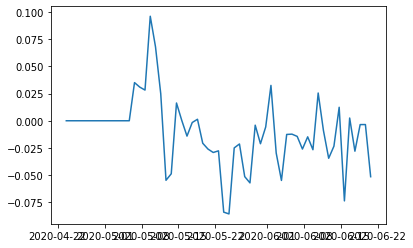



simple_moving_average
                         open       high       low     close         volume
time                                                                       
2020-04-22 16:00:00  7304.540   7676.980  7204.000  7493.695   81477.844750
2020-04-23 16:00:00  7304.540   7676.980  7204.000  7493.695   81477.844750
2020-04-24 16:00:00  7494.480   7660.480  7409.535  7521.835   52028.273832
2020-04-25 16:00:00  7522.015   7702.500  7455.535  7615.885   47198.521967
2020-04-26 16:00:00  7616.065   7746.010  7543.000  7733.860   57981.977892
2020-04-27 16:00:00  7733.305   7786.010  7632.560  7756.800   55872.046107
2020-04-28 16:00:00  7756.045   8366.445  7684.585  8258.775  114924.820076
2020-04-29 16:00:00  8258.580   9206.445  8055.525  8699.285  194912.050819
2020-04-30 16:00:00  8699.290   9259.590  8507.280  8723.480  148873.014591
2020-05-01 16:00:00  8722.835   9034.590  8683.280  8899.505   75235.451304
2020-05-02 16:00:00  8899.125   9105.000  8732.500  8933.105   7

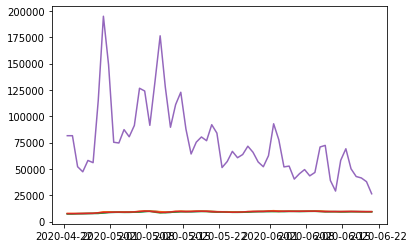



MACD_trigger
time
2020-04-22 16:00:00    0.0
2020-04-23 16:00:00    0.0
2020-04-24 16:00:00    1.0
2020-04-25 16:00:00    1.0
2020-04-26 16:00:00    1.0
2020-04-27 16:00:00    1.0
2020-04-28 16:00:00    1.0
2020-04-29 16:00:00    1.0
2020-04-30 16:00:00    1.0
2020-05-01 16:00:00    1.0
2020-05-02 16:00:00    1.0
2020-05-03 16:00:00    1.0
2020-05-04 16:00:00    1.0
2020-05-05 16:00:00    1.0
2020-05-06 16:00:00    1.0
2020-05-07 16:00:00    1.0
2020-05-08 16:00:00    1.0
2020-05-09 16:00:00    1.0
2020-05-10 16:00:00    0.0
2020-05-11 16:00:00    0.0
2020-05-12 16:00:00    0.0
2020-05-13 16:00:00    1.0
2020-05-14 16:00:00    1.0
2020-05-15 16:00:00    1.0
2020-05-16 16:00:00    1.0
2020-05-17 16:00:00    1.0
2020-05-18 16:00:00    1.0
2020-05-19 16:00:00    1.0
2020-05-20 16:00:00    0.0
2020-05-21 16:00:00    0.0
2020-05-22 16:00:00    0.0
2020-05-23 16:00:00    0.0
2020-05-24 16:00:00    0.0
2020-05-25 16:00:00    0.0
2020-05-26 16:00:00    0.0
2020-05-27 16:00:00    0.0
2020-05-

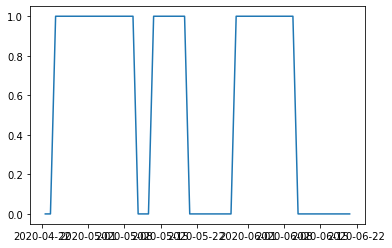



momentum_trigger
time
2020-04-22 16:00:00    1.0
2020-04-23 16:00:00    1.0
2020-04-24 16:00:00    1.0
2020-04-25 16:00:00    1.0
2020-04-26 16:00:00    1.0
2020-04-27 16:00:00    1.0
2020-04-28 16:00:00    1.0
2020-04-29 16:00:00    1.0
2020-04-30 16:00:00    0.0
2020-05-01 16:00:00    0.0
2020-05-02 16:00:00    0.0
2020-05-03 16:00:00    0.0
2020-05-04 16:00:00    0.0
2020-05-05 16:00:00    1.0
2020-05-06 16:00:00    1.0
2020-05-07 16:00:00    1.0
2020-05-08 16:00:00    0.0
2020-05-09 16:00:00    0.0
2020-05-10 16:00:00    0.0
2020-05-11 16:00:00    0.0
2020-05-12 16:00:00    0.0
2020-05-13 16:00:00    1.0
2020-05-14 16:00:00    1.0
2020-05-15 16:00:00    1.0
2020-05-16 16:00:00    1.0
2020-05-17 16:00:00    1.0
2020-05-18 16:00:00    1.0
2020-05-19 16:00:00    1.0
2020-05-20 16:00:00    0.0
2020-05-21 16:00:00    0.0
2020-05-22 16:00:00    0.0
2020-05-23 16:00:00    0.0
2020-05-24 16:00:00    0.0
2020-05-25 16:00:00    0.0
2020-05-26 16:00:00    0.0
2020-05-27 16:00:00    1.0
2020

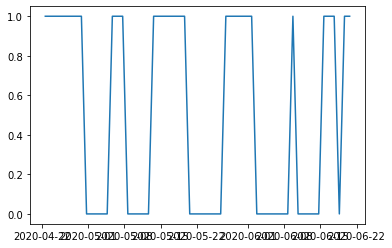



overtraded_trigger
time
2020-04-22 16:00:00    0.0
2020-04-23 16:00:00    0.0
2020-04-24 16:00:00    0.0
2020-04-25 16:00:00    0.0
2020-04-26 16:00:00    0.0
2020-04-27 16:00:00    0.0
2020-04-28 16:00:00    1.0
2020-04-29 16:00:00    0.0
2020-04-30 16:00:00    0.0
2020-05-01 16:00:00    0.0
2020-05-02 16:00:00    0.0
2020-05-03 16:00:00    0.0
2020-05-04 16:00:00    0.0
2020-05-05 16:00:00    1.0
2020-05-06 16:00:00    1.0
2020-05-07 16:00:00    0.0
2020-05-08 16:00:00    0.0
2020-05-09 16:00:00    0.0
2020-05-10 16:00:00    0.0
2020-05-11 16:00:00    0.0
2020-05-12 16:00:00    1.0
2020-05-13 16:00:00    1.0
2020-05-14 16:00:00    0.0
2020-05-15 16:00:00    0.0
2020-05-16 16:00:00    1.0
2020-05-17 16:00:00    1.0
2020-05-18 16:00:00    1.0
2020-05-19 16:00:00    0.0
2020-05-20 16:00:00    0.0
2020-05-21 16:00:00    0.0
2020-05-22 16:00:00    0.0
2020-05-23 16:00:00    0.0
2020-05-24 16:00:00    0.0
2020-05-25 16:00:00    0.0
2020-05-26 16:00:00    1.0
2020-05-27 16:00:00    1.0
20

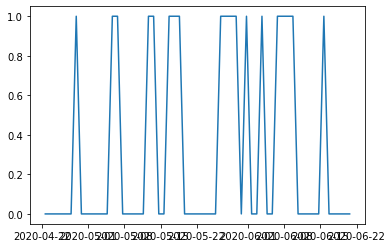



real_trigger
time
2020-04-22 16:00:00    1.0
2020-04-23 16:00:00    1.0
2020-04-24 16:00:00    1.0
2020-04-25 16:00:00    1.0
2020-04-26 16:00:00    1.0
2020-04-27 16:00:00    0.0
2020-04-28 16:00:00    1.0
2020-04-29 16:00:00    0.0
2020-04-30 16:00:00    1.0
2020-05-01 16:00:00    1.0
2020-05-02 16:00:00    0.0
2020-05-03 16:00:00    0.0
2020-05-04 16:00:00    1.0
2020-05-05 16:00:00    1.0
2020-05-06 16:00:00    1.0
2020-05-07 16:00:00    0.0
2020-05-08 16:00:00    0.0
2020-05-09 16:00:00    0.0
2020-05-10 16:00:00    0.0
2020-05-11 16:00:00    1.0
2020-05-12 16:00:00    1.0
2020-05-13 16:00:00    1.0
2020-05-14 16:00:00    0.0
2020-05-15 16:00:00    1.0
2020-05-16 16:00:00    1.0
2020-05-17 16:00:00    1.0
2020-05-18 16:00:00    1.0
2020-05-19 16:00:00    0.0
2020-05-20 16:00:00    0.0
2020-05-21 16:00:00    1.0
2020-05-22 16:00:00    1.0
2020-05-23 16:00:00    0.0
2020-05-24 16:00:00    1.0
2020-05-25 16:00:00    0.0
2020-05-26 16:00:00    1.0
2020-05-27 16:00:00    1.0
2020-05-

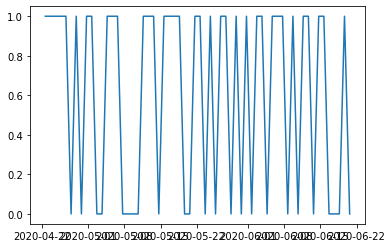



relative_volume_level_trigger
time
2020-04-22 16:00:00    0.0
2020-04-23 16:00:00    0.0
2020-04-24 16:00:00    0.0
2020-04-25 16:00:00    0.0
2020-04-26 16:00:00    0.0
2020-04-27 16:00:00    0.0
2020-04-28 16:00:00    0.0
2020-04-29 16:00:00    0.0
2020-04-30 16:00:00    0.0
2020-05-01 16:00:00    0.0
2020-05-02 16:00:00    0.0
2020-05-03 16:00:00    0.0
2020-05-04 16:00:00    0.0
2020-05-05 16:00:00    0.0
2020-05-06 16:00:00    0.0
2020-05-07 16:00:00    0.0
2020-05-08 16:00:00    0.0
2020-05-09 16:00:00    0.0
2020-05-10 16:00:00    0.0
2020-05-11 16:00:00    0.0
2020-05-12 16:00:00    0.0
2020-05-13 16:00:00    0.0
2020-05-14 16:00:00    0.0
2020-05-15 16:00:00    0.0
2020-05-16 16:00:00    0.0
2020-05-17 16:00:00    0.0
2020-05-18 16:00:00    0.0
2020-05-19 16:00:00    0.0
2020-05-20 16:00:00    0.0
2020-05-21 16:00:00    0.0
2020-05-22 16:00:00    0.0
2020-05-23 16:00:00    0.0
2020-05-24 16:00:00    0.0
2020-05-25 16:00:00    0.0
2020-05-26 16:00:00    0.0
2020-05-27 16:00:0

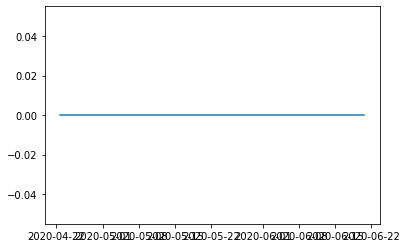



trend_strength_negative_trigger
time
2020-05-18 16:00:00    0.0
2020-05-19 16:00:00    1.0
2020-05-20 16:00:00    1.0
2020-05-21 16:00:00    1.0
2020-05-22 16:00:00    1.0
2020-05-23 16:00:00    1.0
2020-05-24 16:00:00    1.0
2020-05-25 16:00:00    1.0
2020-05-26 16:00:00    0.0
2020-05-27 16:00:00    0.0
2020-05-28 16:00:00    0.0
2020-05-29 16:00:00    0.0
2020-05-30 16:00:00    0.0
2020-05-31 16:00:00    0.0
2020-06-01 16:00:00    0.0
2020-06-02 16:00:00    0.0
2020-06-03 16:00:00    0.0
2020-06-04 16:00:00    0.0
2020-06-05 16:00:00    0.0
2020-06-06 16:00:00    0.0
2020-06-07 16:00:00    0.0
2020-06-08 16:00:00    0.0
2020-06-09 16:00:00    1.0
2020-06-10 16:00:00    1.0
2020-06-11 16:00:00    1.0
2020-06-12 16:00:00    1.0
2020-06-13 16:00:00    1.0
2020-06-14 16:00:00    1.0
2020-06-15 16:00:00    1.0
2020-06-16 16:00:00    1.0
2020-06-17 16:00:00    1.0
2020-06-18 16:00:00    1.0
2020-06-19 16:00:00    1.0
dtype: float64


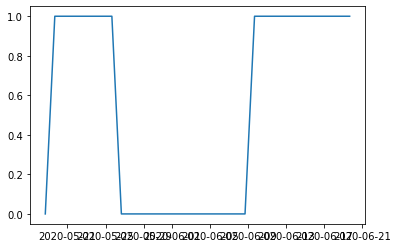



trend_strength_positive_trigger
time
2020-05-18 16:00:00    1.0
2020-05-19 16:00:00    0.0
2020-05-20 16:00:00    0.0
2020-05-21 16:00:00    0.0
2020-05-22 16:00:00    0.0
2020-05-23 16:00:00    0.0
2020-05-24 16:00:00    0.0
2020-05-25 16:00:00    0.0
2020-05-26 16:00:00    1.0
2020-05-27 16:00:00    1.0
2020-05-28 16:00:00    1.0
2020-05-29 16:00:00    1.0
2020-05-30 16:00:00    1.0
2020-05-31 16:00:00    1.0
2020-06-01 16:00:00    1.0
2020-06-02 16:00:00    1.0
2020-06-03 16:00:00    1.0
2020-06-04 16:00:00    1.0
2020-06-05 16:00:00    1.0
2020-06-06 16:00:00    1.0
2020-06-07 16:00:00    1.0
2020-06-08 16:00:00    1.0
2020-06-09 16:00:00    0.0
2020-06-10 16:00:00    0.0
2020-06-11 16:00:00    0.0
2020-06-12 16:00:00    0.0
2020-06-13 16:00:00    0.0
2020-06-14 16:00:00    0.0
2020-06-15 16:00:00    0.0
2020-06-16 16:00:00    0.0
2020-06-17 16:00:00    0.0
2020-06-18 16:00:00    0.0
2020-06-19 16:00:00    0.0
dtype: float64


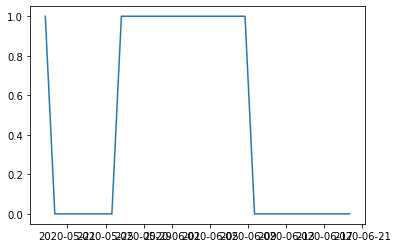



trend_strength_trigger
time
2020-05-18 16:00:00    1.0
2020-05-19 16:00:00    1.0
2020-05-20 16:00:00    0.0
2020-05-21 16:00:00    0.0
2020-05-22 16:00:00    0.0
2020-05-23 16:00:00    1.0
2020-05-24 16:00:00    1.0
2020-05-25 16:00:00    0.0
2020-05-26 16:00:00    0.0
2020-05-27 16:00:00    0.0
2020-05-28 16:00:00    0.0
2020-05-29 16:00:00    0.0
2020-05-30 16:00:00    1.0
2020-05-31 16:00:00    1.0
2020-06-01 16:00:00    1.0
2020-06-02 16:00:00    1.0
2020-06-03 16:00:00    1.0
2020-06-04 16:00:00    1.0
2020-06-05 16:00:00    1.0
2020-06-06 16:00:00    1.0
2020-06-07 16:00:00    1.0
2020-06-08 16:00:00    1.0
2020-06-09 16:00:00    1.0
2020-06-10 16:00:00    1.0
2020-06-11 16:00:00    1.0
2020-06-12 16:00:00    1.0
2020-06-13 16:00:00    1.0
2020-06-14 16:00:00    1.0
2020-06-15 16:00:00    1.0
2020-06-16 16:00:00    1.0
2020-06-17 16:00:00    1.0
2020-06-18 16:00:00    1.0
2020-06-19 16:00:00    1.0
Name: ADX, dtype: float64


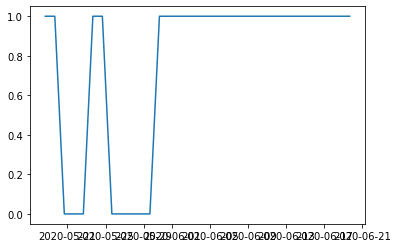



trend_trigger
2020-04-22 16:00:00    1.0
2020-04-23 16:00:00    1.0
2020-04-24 16:00:00    1.0
2020-04-25 16:00:00    1.0
2020-04-26 16:00:00    1.0
2020-04-27 16:00:00    1.0
2020-04-28 16:00:00    1.0
2020-04-29 16:00:00    1.0
2020-04-30 16:00:00    1.0
2020-05-01 16:00:00    1.0
2020-05-02 16:00:00    1.0
2020-05-03 16:00:00    0.0
2020-05-04 16:00:00    1.0
2020-05-05 16:00:00    1.0
2020-05-06 16:00:00    1.0
2020-05-07 16:00:00    1.0
2020-05-08 16:00:00    1.0
2020-05-09 16:00:00    0.0
2020-05-10 16:00:00    0.0
2020-05-11 16:00:00    0.0
2020-05-12 16:00:00    1.0
2020-05-13 16:00:00    1.0
2020-05-14 16:00:00    1.0
2020-05-15 16:00:00    0.0
2020-05-16 16:00:00    1.0
2020-05-17 16:00:00    1.0
2020-05-18 16:00:00    1.0
2020-05-19 16:00:00    0.0
2020-05-20 16:00:00    0.0
2020-05-21 16:00:00    0.0
2020-05-22 16:00:00    0.0
2020-05-23 16:00:00    0.0
2020-05-24 16:00:00    0.0
2020-05-25 16:00:00    0.0
2020-05-26 16:00:00    1.0
2020-05-27 16:00:00    1.0
2020-05-28 1

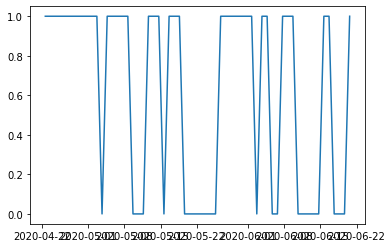



volatility_trigger
time
2020-04-22 16:00:00    0.0
2020-04-23 16:00:00    0.0
2020-04-24 16:00:00    0.0
2020-04-25 16:00:00    0.0
2020-04-26 16:00:00    0.0
2020-04-27 16:00:00    0.0
2020-04-28 16:00:00    0.0
2020-04-29 16:00:00    0.0
2020-04-30 16:00:00    0.0
2020-05-01 16:00:00    0.0
2020-05-02 16:00:00    0.0
2020-05-03 16:00:00    0.0
2020-05-04 16:00:00    0.0
2020-05-05 16:00:00    0.0
2020-05-06 16:00:00    0.0
2020-05-07 16:00:00    0.0
2020-05-08 16:00:00    0.0
2020-05-09 16:00:00    0.0
2020-05-10 16:00:00    0.0
2020-05-11 16:00:00    0.0
2020-05-12 16:00:00    1.0
2020-05-13 16:00:00    1.0
2020-05-14 16:00:00    1.0
2020-05-15 16:00:00    1.0
2020-05-16 16:00:00    1.0
2020-05-17 16:00:00    1.0
2020-05-18 16:00:00    1.0
2020-05-19 16:00:00    1.0
2020-05-20 16:00:00    1.0
2020-05-21 16:00:00    1.0
2020-05-22 16:00:00    1.0
2020-05-23 16:00:00    1.0
2020-05-24 16:00:00    1.0
2020-05-25 16:00:00    1.0
2020-05-26 16:00:00    1.0
2020-05-27 16:00:00    1.0
20

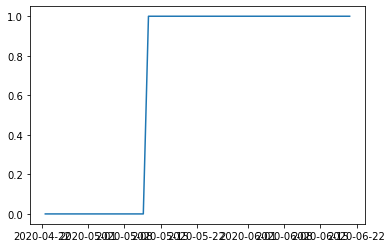

In [5]:
client = Client(api_key, api_secret)

crypto_bot = Cryptocurrency_bot(client=client, 
                                traded_asset_symbols=traded_asset_symbols, 
                                intervals=intervals, 
                                raw_price=raw_price, 
                                initial_plot=initial_plot, 
                                all_pairs=all_pairs)

In [ ]:
def process_message(msg):
    global crypto_bot
    four_hours = 14400
    milliseconds = 1000
    percentage_to_trade = 0.9999

    msg = msg['data']['k']
    symbol = msg['s']
    interval = msg['i']
    pair = crypto_bot.pairs[symbol]
    pair_at_interval = pair.interval[interval]
    dataset = pair_at_interval.dataset
    precision = pair.info.precision
    if symbol in crypto_bot.pairs.keys():
        last_data = \
            pd.DataFrame([["{:0.0{}f}".format(float(msg['o']), precision).rstrip('0').rstrip('.'), 
                           "{:0.0{}f}".format(float(msg['h']), precision).rstrip('0').rstrip('.'), 
                           "{:0.0{}f}".format(float(msg['l']), precision).rstrip('0').rstrip('.'), 
                           "{:0.0{}f}".format(float(msg['c']), precision).rstrip('0').rstrip('.'), 
                           "{:0.0{}f}".format(float(msg['v']), precision).rstrip('0').rstrip('.')]], 
                         index=[datetime.datetime.fromtimestamp(int(msg['t'] / milliseconds) - four_hours)], 
                         columns=['open', 'high', 'low', 'close', 'volume'])

        last_data.index.name = 'time'

        if dataset.index[-1] == last_data.index[-1]:
            dataset = dataset.iloc[:-1].append(last_data).iloc[-100:]
        else:
            dataset = dataset.append(last_data).iloc[-100:]

        pair_at_interval.dataset = dataset
        pair_at_interval.indicators.update(dataset, plot=False)
        pair.info.calculate_balance()
        pair.info.print_balance()

        if symbol == crypto_bot.traded_pair_symbol:
            volatility_trigger = pair_at_interval.indicators.indicators.volatility_trigger.value.iloc[-1]
            MACD_trigger = pair_at_interval.indicators.indicators.MACD_trigger.value.iloc[-1]
            real_trigger = pair_at_interval.indicators.indicators.real_trigger.value.iloc[-1]
            momentum_trigger = pair_at_interval.indicators.indicators.momentum_trigger.value.iloc[-1]

            if pair.state == 'exit':

                if pair.position == 'sell' and \
                        volatility_trigger and \
                        MACD_trigger and \
                        real_trigger and \
                        momentum_trigger:

                    pair.trade(percentage_to_trade=percentage_to_trade)

                elif pair.position == 'buy' and \
                        volatility_trigger and \
                        not MACD_trigger and \
                        not real_trigger and \
                        not momentum_trigger:

                    pair.trade(percentage_to_trade=percentage_to_trade)

            elif pair.state == 'entry':

                if pair.position == 'sell' and \
                        volatility_trigger and \
                        MACD_trigger and \
                        real_trigger and \
                        momentum_trigger:

                    pair.trade(percentage_to_trade=percentage_to_trade)

                elif pair.position == 'buy' and \
                        volatility_trigger and \
                        not MACD_trigger and \
                        not real_trigger and \
                        not momentum_trigger:

                    pair.trade(percentage_to_trade=percentage_to_trade)


bm = BinanceSocketManager(client, user_timeout=43200)

sockets = []

for interval in intervals:
    for symbol in crypto_bot.pairs.keys():
        sockets.append(symbol.lower() + '@kline_' + interval)

conn_key = bm.start_multiplex_socket(sockets, process_message)

bm.start()


while True:
    time.sleep(30)

    crypto_bot.assets = dict.fromkeys(crypto_bot.assets.keys(), 0)

    for pair in crypto_bot.pairs.keys():
        crypto_bot.pairs[pair].info.calculate_balance()
        crypto_bot.pairs[pair].calculate_position()

    for asset in crypto_bot.assets.keys():
        for pair in crypto_bot.pairs.keys():
            if crypto_bot.pairs[pair].info.base_asset == asset:
                if crypto_bot.pairs[pair].interval[intervals[0]].indicators.indicators.real_trigger.value.iloc[-1] and \
                        crypto_bot.pairs[pair].interval[intervals[0]].indicators.indicators.relative_volume_level_trigger.value.iloc[-1]:

                    crypto_bot.assets[asset] += 1
                else:
                    crypto_bot.assets[asset] -= 1

            elif crypto_bot.pairs[pair].info.quote_asset == asset:
                if crypto_bot.pairs[pair].interval[intervals[0]].indicators.indicators.real_trigger.value.iloc[-1] and \
                        crypto_bot.pairs[pair].interval[intervals[0]].indicators.indicators.relative_volume_level_trigger.value.iloc[-1]:

                    crypto_bot.assets[asset] -= 1
                else:
                    crypto_bot.assets[asset] += 1

    best_assets = [asset for asset in crypto_bot.assets.keys() if crypto_bot.assets[asset] > 0]
    print('best_assets: ', best_assets)

    if best_assets != [] and \
            not (crypto_bot.pairs[crypto_bot.traded_pair_symbol].info.base_asset in best_assets or \
            crypto_bot.pairs[crypto_bot.traded_pair_symbol].info.quote_asset in best_assets):

        if crypto_bot.pairs[crypto_bot.traded_pair_symbol].position == 'buy':
            asset = crypto_bot.pairs[crypto_bot.traded_pair_symbol].info.base_asset
        elif crypto_bot.pairs[crypto_bot.traded_pair_symbol].position == 'sell':
            asset = crypto_bot.pairs[crypto_bot.traded_pair_symbol].info.quote_asset

        target_symbols = [pair for pair in crypto_bot.pairs.keys() \
                          if asset in pair and any([asset in pair for asset in best_assets])]

        target_symbol = target_symbols[0]
        crypto_bot.pairs[target_symbol].state = 'exit'

        if crypto_bot.pairs[target_symbol].info.base_asset == asset:
            crypto_bot.pairs[target_symbol].position = 'buy'
            crypto_bot.traded_asset_symbol = crypto_bot.pairs[target_symbol].info.base_asset
        elif crypto_bot.pairs[target_symbol].info.quote_asset == asset:
            crypto_bot.pairs[target_symbol].position = 'sell'
            crypto_bot.traded_asset_symbol = crypto_bot.pairs[target_symbol].info.quote_asset

        crypto_bot.traded_pair_symbol = target_symbol


'''
def process_message(msg):
    global symbols, traded_symbol
    four_hours = 14400
    milliseconds = 1000

    msg = msg['data']['k']
    symbol = msg['s']
    dataset = symbols[symbol].dataset
    quote_asset_precision = symbols[symbol].quote_asset_precision
    if symbol in symbols.keys():
        last_data = \
            pd.DataFrame([["{:0.0{}f}".format(float(msg['o']), quote_asset_precision).rstrip('0').rstrip('.'), 
                           "{:0.0{}f}".format(float(msg['h']), quote_asset_precision).rstrip('0').rstrip('.'), 
                           "{:0.0{}f}".format(float(msg['l']), quote_asset_precision).rstrip('0').rstrip('.'), 
                           "{:0.0{}f}".format(float(msg['c']), quote_asset_precision).rstrip('0').rstrip('.'), 
                           "{:0.0{}f}".format(float(msg['v']), quote_asset_precision).rstrip('0').rstrip('.')]], 
                         index=[datetime.datetime.fromtimestamp(int(msg['t'] / milliseconds) - four_hours)], 
                         columns=['open', 'high', 'low', 'close', 'volume'])

        last_data.index.name = 'time'

        if dataset.index[-1] == last_data.index[-1]:
            dataset = dataset.iloc[:-1].append(last_data).iloc[-1000:]
        else:
            dataset = dataset.append(last_data).iloc[-1000:]

        symbols[symbol].dataset = dataset
        symbols[symbol].calculate_indicators()

        if symbol == traded_symbol:
            if symbols[symbol].state == 'exit':

                if symbols[symbol].position == 'sell' and \
                        symbols[symbol].volatility_trigger.iloc[-1] and \
                        symbols[symbol].MACD_trigger.iloc[-1] and \
                        symbols[symbol].real_trigger.iloc[-1] and \
                        symbols[symbol].momentum_trigger.iloc[-1]:

                    symbols[symbol].trade()

                elif symbols[symbol].position == 'buy' and \
                        symbols[symbol].volatility_trigger.iloc[-1] and \
                        not symbols[symbol].MACD_trigger.iloc[-1] and \
                        not symbols[symbol].real_trigger.iloc[-1] and \
                        not symbols[symbol].momentum_trigger.iloc[-1]:

                    symbols[symbol].trade()

            elif symbols[symbol].state == 'entry':

                if symbols[symbol].position == 'sell' and \
                        symbols[symbol].volatility_trigger.iloc[-1] and \
                        symbols[symbol].MACD_trigger.iloc[-1] and \
                        symbols[symbol].real_trigger.iloc[-1] and \
                        symbols[symbol].momentum_trigger.iloc[-1]:

                    symbols[symbol].trade()

                elif symbols[symbol].position == 'buy' and \
                        symbols[symbol].volatility_trigger.iloc[-1] and \
                        not symbols[symbol].MACD_trigger.iloc[-1] and \
                        not symbols[symbol].real_trigger.iloc[-1] and \
                        not symbols[symbol].momentum_trigger.iloc[-1]:

                    symbols[symbol].trade()

bm = BinanceSocketManager(client, user_timeout=43200)
conn_key = bm.start_multiplex_socket([symbol.lower() + '@kline_' + interval for symbol in symbols.keys()], 
                                     process_message)
bm.start()
'''



pair:  BTCUSDT
base_asset_balance:  0.00820334
quote_asset_balance:  0
pair_last_price:  9310.7
pair_buy_balance:  0
pair_sell_balance:  76.37883774
pair_combined_base_balance:  0.00820334
pair_combined_quote_balance:  76.37883774




pair:  BTCUSDT
base_asset_balance:  0.00820334
quote_asset_balance:  0
pair_last_price:  9312.96
pair_buy_balance:  0
pair_sell_balance:  76.39737729
pair_combined_base_balance:  0.00820334
pair_combined_quote_balance:  76.39737729




pair:  BTCUSDT
base_asset_balance:  0.00820334
quote_asset_balance:  0
pair_last_price:  9312.12
pair_buy_balance:  0
pair_sell_balance:  76.39048648
pair_combined_base_balance:  0.00820334
pair_combined_quote_balance:  76.39048648




pair:  BTCUSDT
base_asset_balance:  0.00820334
quote_asset_balance:  0
pair_last_price:  9312.12
pair_buy_balance:  0
pair_sell_balance:  76.39048648
pair_combined_base_balance:  0.00820334
pair_combined_quote_balance:  76.39048648




pair:  BTCUSDT
base_asset_balance:  0.00820334
quote_as

In [ ]:
#bm.stop_socket(conn_key)
#bm.close()
#reactor.stop()